In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers

ModuleNotFoundError: No module named 'tensorflow.keras'

In [2]:
train_dir = './chest_xray/train'
test_dir = './chest_xray/test'

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHAANNELS = 3

In [4]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5232 files belonging to 2 classes.


In [5]:
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 624 files belonging to 2 classes.


In [6]:
class_names = dataset_test.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [7]:
len(dataset_train)

164

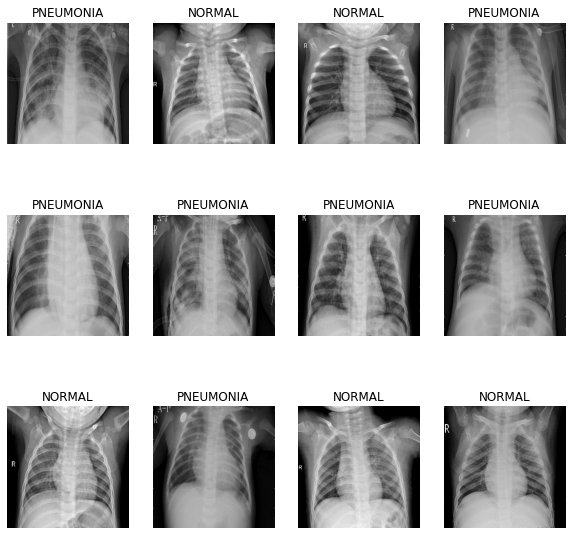

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% is are training dataset 
# 10% is are validation dataset

def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size = 1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int( val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [10]:
train_ds, val_ds,  = get_dataset_partitions_tf(dataset_train)
len(train_ds)

147

In [11]:
0.8*164

131.20000000000002

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = dataset_test.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHAANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [20]:
history = model.fit(
    train_ds,
    epochs=5,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
147/147 [==============================] - 420s 3s/step - loss: 0.5757 - accuracy: 0.7436 - val_loss: 0.5215 - val_accuracy: 0.8730
Epoch 2/5
147/147 [==============================] - 366s 2s/step - loss: 0.3197 - accuracy: 0.8724 - val_loss: 0.2739 - val_accuracy: 0.9121
Epoch 3/5
147/147 [==============================] - 337s 2s/step - loss: 0.2545 - accuracy: 0.9002 - val_loss: 0.2082 - val_accuracy: 0.9180
Epoch 4/5
147/147 [==============================] - 277s 2s/step - loss: 0.2205 - accuracy: 0.9160 - val_loss: 0.2076 - val_accuracy: 0.9336
Epoch 5/5
147/147 [==============================] - 340s 2s/step - loss: 0.1861 - accuracy: 0.9339 - val_loss: 0.2245 - val_accuracy: 0.9395


In [ ]:
model.save('chest_xray.keras')

In [ ]:
new_model = tf.keras.models.load_model('chest_xray.keras')

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1): 
    
    first_im = images_batch[5].numpy().astype("uint8")
    first_label = labels_batch[5].numpy()
    
    plt.imshow(first_im)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [25]:
model.evaluate(test_ds)

20/20 [==============================] - 10s 328ms/step - loss: 0.3265 - accuracy: 0.8814


[0.32647958397865295, 0.8814102411270142]

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training & Validation loss')

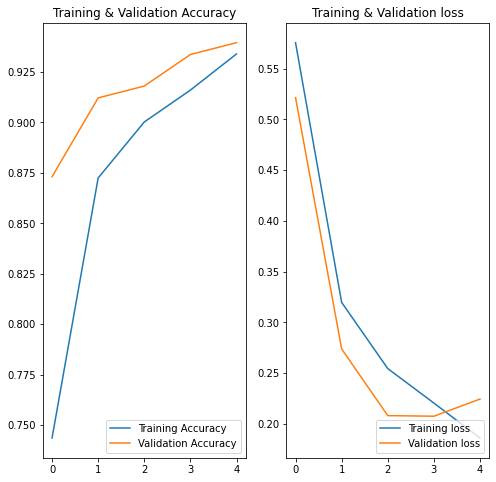

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(5),acc, label="Training Accuracy")
plt.plot(range(5),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(5),loss, label="Training loss")
plt.plot(range(5),val_loss, label="Validation loss")
plt.legend(loc="lower right")
plt.title('Training & Validation loss')